In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 14

2023-03-05 21:15:58.658229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 21:16:10.234086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/samjoel/anaconda3/lib/:/home/samjoel/anaconda3/lib/python3.8/site-packages/tensorrt/:/home/samjoel/anaconda3/envs/mlops_train/lib/
2023-03-05 21:16:10.234620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRAR

# Transfer Learning: Finetuning

- Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. - Generic Wiki Definition
- The early convolutional layers in a CNN extract generic features and become more specific to the training data as we go deeper into the network.
- Due to this behaviour of CNNs we can choose a level of extracting features for a given problem statement.
- An example of transfer learning can be seen in the image below where the final classification layer of the network is changed and is kept as the only trainable layer in the network leveraging the weights of the network previously trained

<img src="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/04/13204041/1.png" height="400" width="800">

- Choosing the appropriate level for transfer learning is dependent on two important factors
    - **Size of the dataset:** Small or Large ?
    - **Similarity of Domain:** Source and Target datasets Same or Different?
- The factors state above lead to the following four combination of scenarios
    1. Target dataset is **small and similar** to the source dataset
    2. Target dataset is **small but different** than the source dataset
    3. Target dataset is **large and similar** to the source dataset
    4. Target dataset is **large but different** than the source dataset

In [3]:
train_dir = './data/seg_train'
test_dir = './data/seg_test'

# Data Generator

In [4]:
batch_size = 32
img_size = 224
directory = './data/initial_dataset'


datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.15)

train_generator = datagen.flow_from_directory(directory,  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

validation_generator = datagen.flow_from_directory(directory,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    subset='validation',
                                                    class_mode='categorical')

Found 10646 images belonging to 6 classes.
Found 1875 images belonging to 6 classes.


In [8]:
len(np.unique(train_generator.classes))

6

# Determining the Similarity of Domain
- We need to find out how similar are the images of our dataset to the ones of Imagenet-1000 on which the complex architectures have been built

## Intel Images Dataset Samples

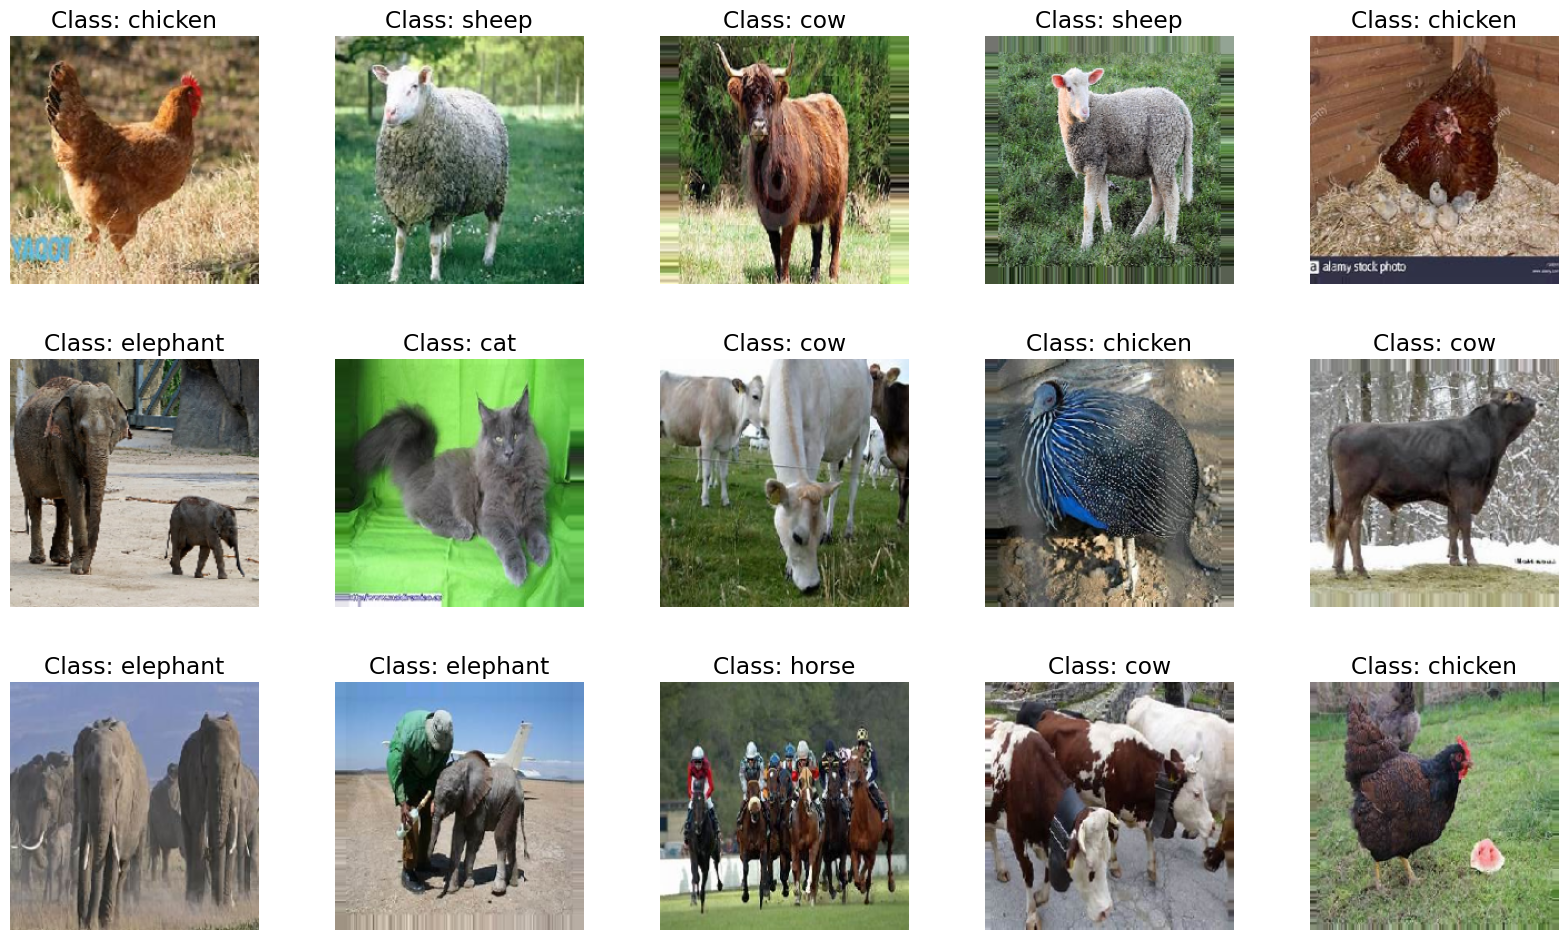

In [3]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

## Imagenet Images Dataset Samples

<img src="https://devopedia.org/images/article/172/7316.1561043304.png" height="400" width="800">

- The full list of classes of the Imagenet Dataset can be found on this link: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
- After going through the list of classes I found that there were classes of different animals present in the Imagenet Dataset
- **Conclusion:** The domain of the dataset is similar

# Finetuning Approach

| Size of the target dataset | Similarity of target and source dataset | Approach |
| --- | --- | --- |
| Small | Similar | Use the pretrained network for feature extraction and train the last layer for classification, or you can train a separate ML model to train on the extracted features |
| Large | Similar | Freeze approximately 60-80% of the pretrained network and retrain the weights of the layers of the remaining part of the network **(Our Case)** |
| Small | Different | Since the dataset is different it might not be good idea to freeze the higher level layers which capture features specific to the image dataset. We also cannot finetune through the entire network as the target dataset is small which might lead to overfitting. Therefore freeze first third or half of the pretrained network so that they capture the low level features like edges, colors, etc. and retrain the remaining part of the network  |
| Large | Different | Since the target dataset is large and the domain is different a good idea would be to leverage the weight initialization of the pretrained network, as this will help your model converge faster, and retrain the entire network on your target dataset |

<img src='https://miro.medium.com/max/861/0*6VP81rFoLWp10FcG'>

In [4]:
img_size = 224
base_model = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

2023-03-05 15:49:10.955807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 15:49:11.614578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 15:49:11.614796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 15:49:11.648184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

## VGG16 Reference

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F5066898%2Fd56c89bbad2c59261b7c51c160e3d7b7%2FVGG16_Summary-Table.jpg?generation=1598797630439321&alt=media">

In [5]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Freeze the Lower layers
- Since we have a medium-large dataset with a similar dataset domain than the source we will freeze 60-80% of the architecture
- For VGG-16, I have used my knowledge about the architecture and have frozen the first few convolutional blocks of the architecture

In [6]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## New Model Head
- Add more dense layers to the pretrained architecture suiting the needs of the problem in hand
- An important step here is to **keep the learning rate low** so that the weights learnt during finetuning are not very different than the strong feature extracting weights learnt by the pretrained network on the Imagenet Dataset 

In [8]:
from tensorflow.keras.optimizers import Adam

In [9]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Training Callbacks
- Checkpoint the model with the best validation loss
- Stop the training earlier than the set epochs if the validation loss does not decrease after 5 continous epochs
- Reduce the learning rate by 30% if the validation loss does not decrease after 3 continous epochs

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [13]:
try:
    history = model.fit(train_generator,
                        epochs=5,
                        validation_data=validation_generator,
                        callbacks=[checkpoint,earlystopping])
except KeyboardInterrupt:
    print("\nTraining Stopped")

2023-03-05 15:50:01.633385: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


Epoch 1/5


2023-03-05 15:50:10.448906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-05 15:50:25.463695: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-05 15:50:25.463758: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-05 15:50:25.463766: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

333/333 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.7321

2023-03-05 15:55:16.932910: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2023-03-05 15:55:18.888633: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2023-03-05 15:55:19.123157: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2023-03-05 15:55:19.459131: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.34644, saving model to model.h5
333/333 [==============================] - 343s 902ms/step - loss: 0.7180 - accuracy: 0.7321 - val_loss: 0.3464 - val_accuracy: 0.8811
Epoch 2/5
333/333 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8909
Epoch 2: val_loss improved from 0.34644 to 0.31647, saving model to model.h5
333/333 [==============================] - 254s 763ms/step - loss: 0.3201 - accuracy: 0.8909 - val_loss: 0.3165 - val_accuracy: 0.8827
Epoch 3/5
333/333 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9165
Epoch 3: val_loss improved from 0.31647 to 0.23494, saving model to model.h5
333/333 [==============================] - 140s 420ms/step - loss: 0.2476 - accuracy: 0.9165 - val_loss: 0.2349 - val_accuracy: 0.9227
Epoch 4/5
333/333 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.9385
Epoch 4: val_loss improved from 0.23494 to 0.22372, saving model to model.h5
333/3

In [ ]:
model = tf.keras.models.load_model("/kaggle/working/model.h5")

# Learning Curves
- If you do not add dropout in the fully connected layers the network will definitely overfit
- Although there is a difference in training and validation loss curves it is not very large

## Loss Curve

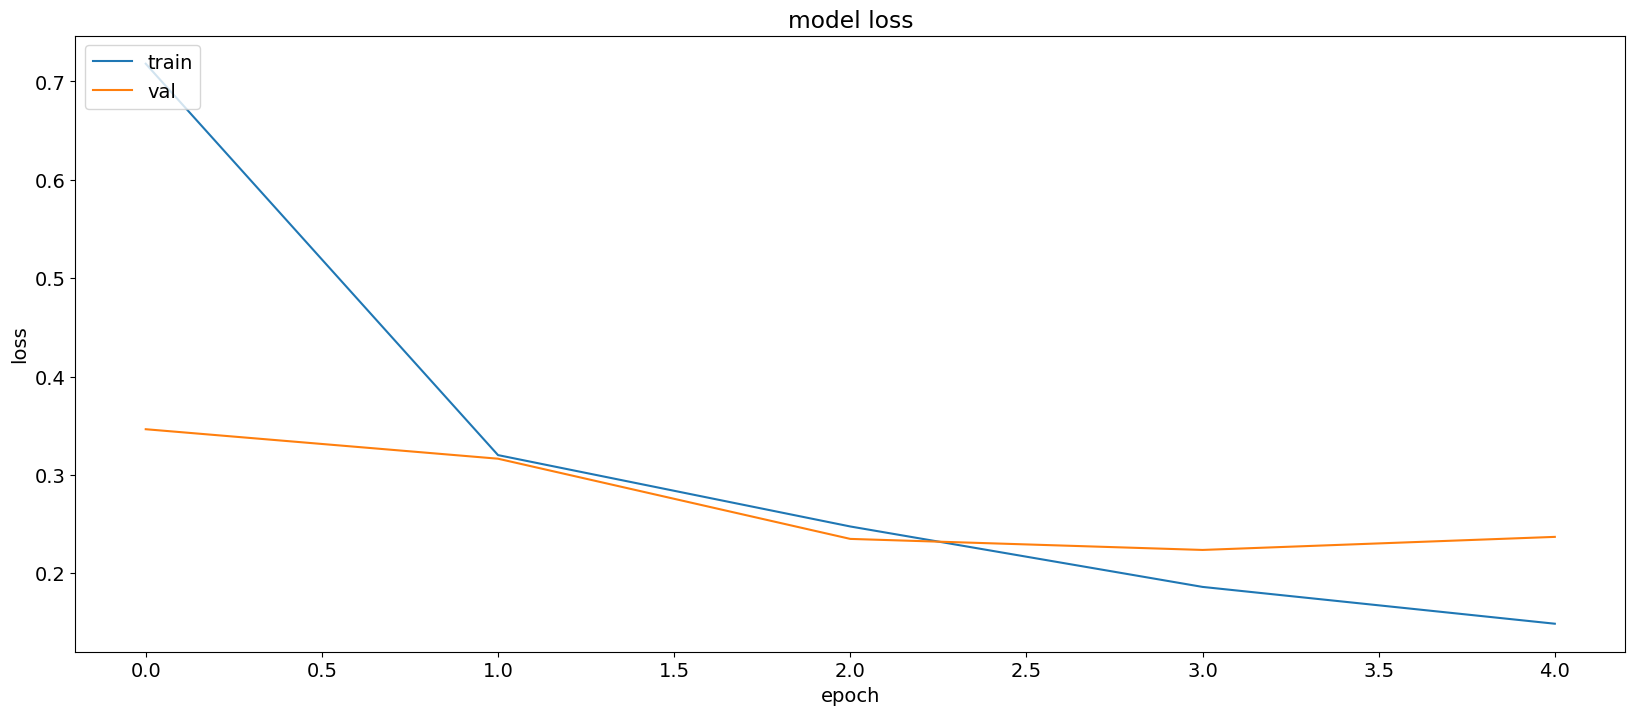

In [14]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Accuracy Curve

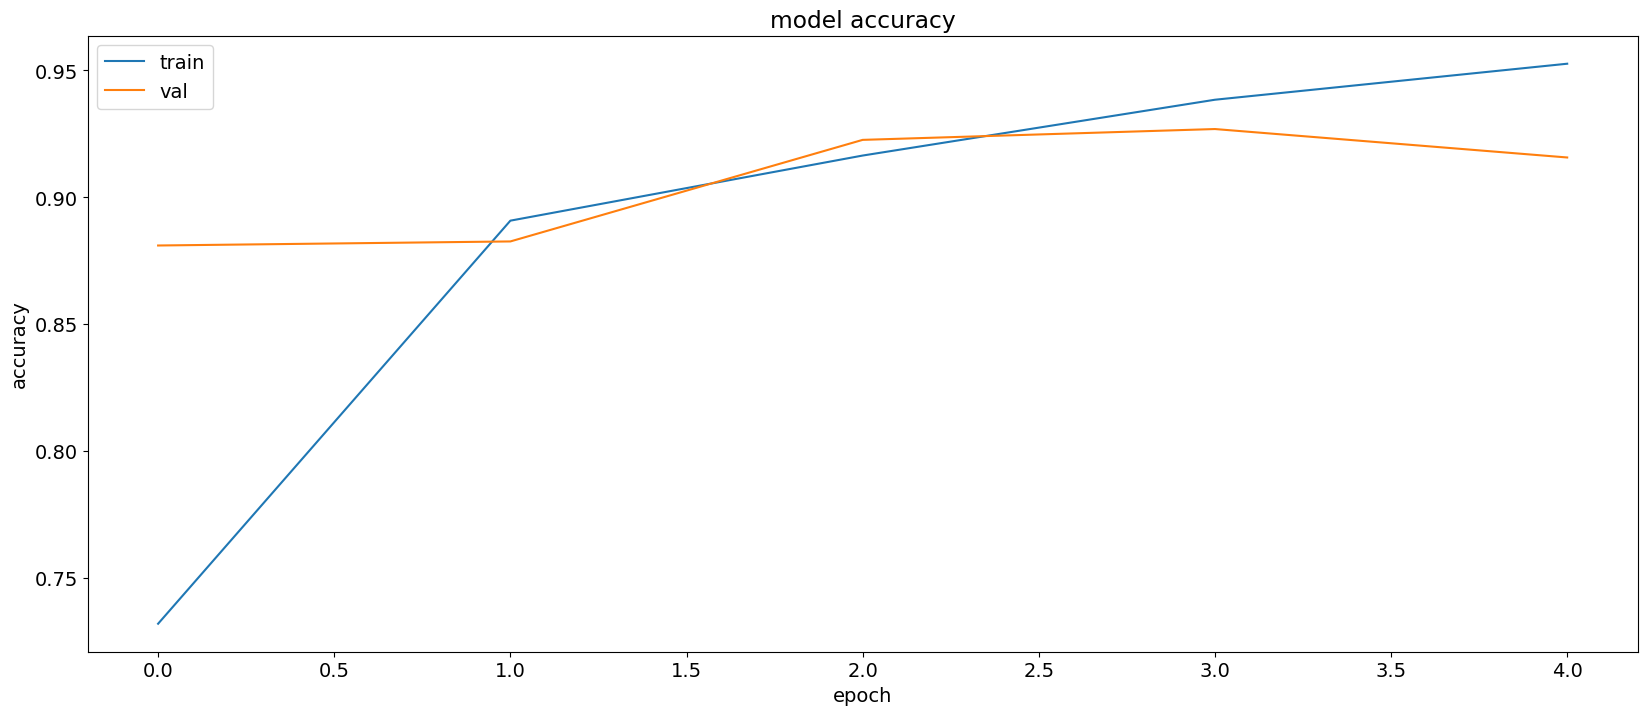

In [15]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

# Evaluation Metrics

## Classification Report
- Identify the classes which are giving a good score and the classes which are giving a bad score and explore those classes further

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

        cane       0.87      0.94      0.90       729
     cavallo       0.94      0.91      0.92       393
    elefante       0.94      0.88      0.91       216
    farfalla       0.93      0.97      0.95       316
     gallina       0.98      0.92      0.95       464
       gatto       0.91      0.90      0.91       250
       mucca       0.89      0.86      0.88       279
      pecora       0.88      0.84      0.86       273
       ragno       0.98      0.97      0.97       723
  scoiattolo       0.86      0.92      0.89       279

    accuracy                           0.92      3922
   macro avg       0.92      0.91      0.91      3922
weighted avg       0.92      0.92      0.92      3922



## Confusion Matrix

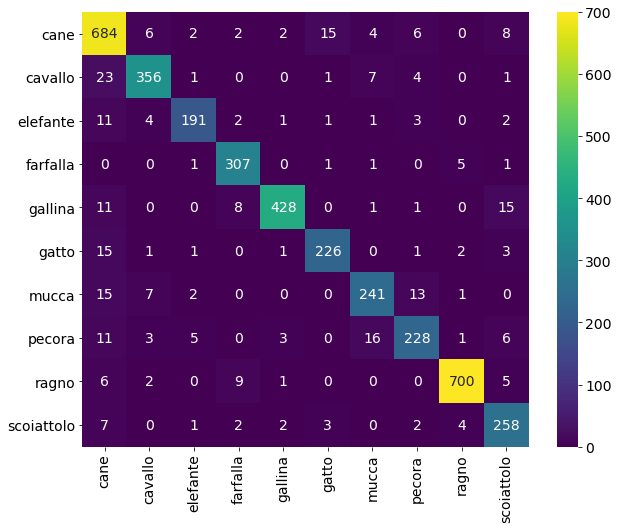

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=labels,yticklabels=labels,cmap='viridis')
plt.show()